# **Section 1: Setups and Imports** <a id="1"></a>

In [1]:
# 🚀 Always run this cell first! It contains all necessary imports.
import gc
import sys
import pprint
import os

import requests
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import joblib

import gym # openai gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim

import random

import csv

# **Section 2: Functions** <a id="2"></a>

## **2.1. Domain Functions** <a id="2.1"></a>

## **2.2. Utility Functions** <a id="2.2"></a>

# **Section 3: Load Data** <a id="3"></a>

In [2]:
# Example NHL play-by-play API URL (game ID will change per game)
game_id = "2022030411"  # Change this to other game IDs if needed
url = f"https://api-web.nhle.com/v1/gamecenter/{game_id}/play-by-play"

# Fetch data from API
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    
    # Extract relevant events
    events = data.get("plays", [])
    away_Team = data.get("awayTeam", [])
    home_Team = data.get("homeTeam", [])
    extracted_data = []

    for event in events:
        event_details = event.get("details", {})
        event_data = {
            "eventId": event.get("eventId"),
            "period": event.get("periodDescriptor", {}).get("number"),
            "time": event.get("timeInPeriod"),
            "away_team": away_Team.get("abbrev"),
            "home_team": home_Team.get("abbrev"),
            "home_team_side": event.get("homeTeamDefendingSide"),
            "eventType": event.get("typeDescKey"),
        }
        # Add event details to event_data
        if event_details:
            for key, value in event_details.items():
                event_data[key] = value
        
        extracted_data.append(event_data)

    # Convert to DataFrame
    df = pd.DataFrame(extracted_data)

    # Save to CSV
    df.to_csv("../data/csv/nhl_play_by_play.csv", index=False)
    print("Data saved to nhl_play_by_play.csv")

else:
    print("Failed to retrieve data from NHL API. Status code:", response.status_code)


Data saved to nhl_play_by_play.csv


In [3]:
print(f"List of eventType: {df['eventType'].unique()}")

List of eventType: ['period-start' 'faceoff' 'hit' 'blocked-shot' 'stoppage' 'takeaway'
 'giveaway' 'shot-on-goal' 'missed-shot' 'penalty' 'goal'
 'delayed-penalty' 'period-end' 'game-end']


In [ ]:
# Define relevant play-driving events
play_events = ["shot-on-goal", "hit", "blocked-shot", "takeaway", "giveaway", "missed-shot"]

# Filter dataset to keep only these events
df_filtered = df[df["eventType"].str.lower().isin(play_events)]


event_counts = df_filtered['eventType'].value_counts()

#print list of eventType and their counts
print(f"List of eventType after filtering: {df_filtered['eventType'].unique()}")
print(event_counts)



List of eventType after filtering: ['hit' 'blocked-shot' 'takeaway' 'giveaway' 'shot-on-goal' 'missed-shot'
 'goal']


In [ ]:
# Replace "shot-on-goal" and "missed-shot" with "shot"
# Both actions will be treated the same - a person doesn't choose to miss a shot, thats an outcome.  We will reward more if shot leads to a goal
df_filtered["eventType"] = df_filtered["eventType"].replace(
    ["shot-on-goal", "missed-shot"], "shot"
)

In [ ]:
# Map the eventOwnerTeamID (i.e. who initiated the action) from ID to a more readable team name
# Retrieve ID:Team mapping from the NHL API

import requests

response = requests.get("https://statsapi.web.nhl.com/api/v1/teams")
data = response.json()
team_data = data.get("teams", [])
team_id_map = {team["id"]: team["triCode"] for team in team_data}

print(team_id_map)

In [44]:
# Post-processing: add synthetic actions like pass, carry-in, or dump-in between events
# Why? → This ensures AI learns logical movement patterns.
#🔹 Now, synthetic actions have proper state values (time, x/y position, etc.).
#🔹 This ensures AI learns logical movement patterns.

import random

def infer_pass_or_carry(row, next_row):
    """Infer synthetic actions like pass, carry-in, or dump-in between events."""
    
    if row["eventOwnerTeamId"] == next_row["eventOwnerTeamId"]:  # Same team possession
        if abs(next_row["xCoord"] - row["xCoord"]) > 20:  # Large movement
            action = "carry-in"
            x_coord = row["xCoord"] + random.randint(5, 15)  # Move puck forward
        else:
            action = "pass"
            x_coord = row["xCoord"] + random.randint(-5, 5)  # Slight variation
        
        y_coord = row["yCoord"] + random.randint(-3, 3)  # Small lateral adjustment
        # Convert time to seconds, add 1, then convert back to mm:ss format
        minutes, seconds = map(int, row["time"].split(":"))
        total_seconds = minutes * 60 + seconds + 1
        time = f"{total_seconds // 60:02}:{total_seconds % 60:02}"
        return pd.Series([action, x_coord, y_coord, time])
    
    return pd.Series([None, None, None, None])  # No synthetic action

# Apply to dataset
df_filtered[["syntheticEvent", "xCoord", "yCoord", "time"]] = df_filtered.apply(
    lambda row: infer_pass_or_carry(row, df_filtered.iloc[row.name + 1]) 
    if row.name < len(df_filtered) - 1 else [None, None, None, None], axis=1
)

# Print sample of synthetic events for debugging
print("Sample of synthetic events:")
print(df_filtered[["syntheticEvent", "xCoord", "yCoord", "time"]].head(10))

# Merge synthetic actions into main action column
df_filtered["eventType"] = df_filtered["eventType"].fillna(df_filtered["syntheticEvent"])
df_filtered = df_filtered.drop(columns=["syntheticEvent"])

# Check for missing events after merging
missing_events = df_filtered[df_filtered["eventType"].isnull()]
if not missing_events.empty:
    print("Missing events detected:")
    print(missing_events)


if not missing_events.empty:
    print("Investigating the rows with missing events...")
    for index, row in missing_events.iterrows():
        print(f"Row {index}: {row}")

print("Output of infer_pass_or_carry:")
print(df_filtered[["eventType", "xCoord", "yCoord", "time"]].head(10))

# Print a small sample to spot check
print(df_filtered.head(10))

Sample of synthetic events:
  syntheticEvent  xCoord  yCoord   time
0           pass    92.0    40.0  00:26
1           None     NaN     NaN   None
2       carry-in   -82.0    34.0  00:35
3       carry-in   -46.0   -10.0  00:54
4           pass   -34.0   -27.0  01:11
5           None     NaN     NaN   None
6       carry-in    11.0   -34.0  01:14
7           pass    55.0   -37.0  01:23
8           None     NaN     NaN   None
9           pass   -73.0    10.0  01:44
Output of infer_pass_or_carry:
      eventType  xCoord  yCoord   time
0           hit    92.0    40.0  00:26
1           hit     NaN     NaN   None
2           hit   -82.0    34.0  00:35
3  blocked-shot   -46.0   -10.0  00:54
4      takeaway   -34.0   -27.0  01:11
5      giveaway     NaN     NaN   None
6           hit    11.0   -34.0  01:14
7           hit    55.0   -37.0  01:23
8  shot-on-goal     NaN     NaN   None
9   missed-shot   -73.0    10.0  01:44
   eventId  period   time away_team home_team home_team_side     eventTy

In [5]:
print(f"List of columns: {df_filtered.columns}")

List of columns: Index(['eventId', 'period', 'time', 'away_team', 'home_team', 'home_team_side',
       'eventType', 'eventOwnerTeamId', 'losingPlayerId', 'winningPlayerId',
       'xCoord', 'yCoord', 'zoneCode', 'hittingPlayerId', 'hitteePlayerId',
       'blockingPlayerId', 'shootingPlayerId', 'reason', 'playerId',
       'shotType', 'goalieInNetId', 'awaySOG', 'homeSOG', 'secondaryReason',
       'typeCode', 'descKey', 'duration', 'committedByPlayerId',
       'drawnByPlayerId', 'scoringPlayerId', 'scoringPlayerTotal',
       'assist1PlayerId', 'assist1PlayerTotal', 'awayScore', 'homeScore',
       'discreteClip', 'assist2PlayerId', 'assist2PlayerTotal',
       'servedByPlayerId'],
      dtype='object')


**Selected Key Columns**
Since the dataset has 39 columns, I reduced it to only the necessary ones for our RL model:

- Game Context: eventId, period, time, away_team, home_team, home_team_side
- Event Type: eventType, eventOwnerTeamId
- Location Data: xCoord, yCoord (where the event happened)
- Shot Details (if applicable): shotType, goalieInNetId
- Game Score: awayScore, homeScore

In [6]:
# Select only relevant columns
df_filtered = df_filtered[[
    "eventId", "period", "time", "away_team", "home_team", "home_team_side",
    "eventType", "eventOwnerTeamId", "xCoord", "yCoord", "zoneCode",
    "shotType", "goalieInNetId", "awayScore", "homeScore"
]]

In [ ]:
# Set team to train on, and filter it in the data set
team_to_train = "home"  # or "away"

df_filtered = df[df["team"] == team_to_train]  # Only include actions for selected team


In [7]:
# Save cleaned data
df_filtered.to_csv("../data/csv/nhl_filtered_play_by_play.csv", index=False)

saved_data = pd.read_csv("../data/csv/nhl_filtered_play_by_play.csv")
print(f"Sample of saved data:\n{saved_data.head()}")
print("Filtered data saved as nhl_filtered_play_by_play.csv")

Sample of saved data:
   eventId  period   time away_team home_team home_team_side     eventType  \
0        8       1  00:23       FLA       VGK          right           hit   
1        9       1  00:27       FLA       VGK          right           hit   
2       10       1  00:32       FLA       VGK          right           hit   
3       53       1  00:51       FLA       VGK          right  blocked-shot   
4       12       1  01:08       FLA       VGK          right      takeaway   

   eventOwnerTeamId  xCoord  yCoord zoneCode shotType  goalieInNetId  \
0              13.0    89.0    31.0        O      NaN            NaN   
1              13.0   -14.0    40.0        N      NaN            NaN   
2              54.0   -86.0    36.0        O      NaN            NaN   
3              54.0   -85.0   -13.0        D      NaN            NaN   
4              54.0   -28.0   -26.0        O      NaN            NaN   

   awayScore  homeScore  
0        NaN        NaN  
1        NaN        NaN 

In [ ]:
# Load the cleaned play-by-play data
df_filtered = pd.read_csv("../data/csv/nhl_filtered_play_by_play.csv")

# Define the Hockey RL Environment (an instance of the OpenAI Gym environment for Reinforcement Learning)
# This version of environment does not include any RL logic, only the basic structure
# Called behavior cloning, where the RL agent learns to mimic the expert's actions (i.e. just follows that's in the data)
class HockeyPlayRL(gym.Env):
    def __init__(self, df):
        super(HockeyPlayRL, self).__init__()

        # Save data
        self.df = df.reset_index(drop=True) # Reset index to avoid issues with step function

        # Define action space (7 possible actions: pass, shoot, carry, dump, and other actions)
        self.action_space = spaces.Discrete(7)

        # Define observation space (state variables: period, time, x, y, score diff)
        self.observation_space = spaces.Box(
            low=np.array([1, 0, -100, -50, -10]),   # Min values for period, time, xCoord, yCoord, scoreDiff
            high=np.array([3, 1200, 100, 50, 10]), # Max values for period, time, xCoord, yCoord, scoreDiff
            dtype=np.float32
        )

        # Initialize game state
        self.current_step = 0

    def reset(self):
        """Reset the environment at the beginning of an episode."""
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        """Get current game state as RL observation."""
        row = self.df.iloc[self.current_step]

        # Convert game state into numerical features
        period = row["period"]
        time = int(row["time"].split(":")[0]) * 60 + int(row["time"].split(":")[1])  # Convert time to seconds
        xCoord = row["xCoord"] if not np.isnan(row["xCoord"]) else 0
        yCoord = row["yCoord"] if not np.isnan(row["yCoord"]) else 0
        scoreDiff = (row["awayScore"] - row["homeScore"]) if not np.isnan(row["awayScore"]) else 0

        return np.array([period, time, xCoord, yCoord, scoreDiff], dtype=np.float32)

    def step(self, action):
        """Apply an action and transition to the next state."""
        row = self.df.iloc[self.current_step]

        # Assign rewards based on event type
        reward = 0
        if row["eventType"] == "hit":
            reward = 1
        elif row["eventType"] == "blocked-shot":
            reward = 5
        elif row["eventType"] == "takeaway":
            reward = 3
        elif row["eventType"] == "giveaway":
            reward = -5
        elif row["eventType"] == "shot-on-goal":
            reward = 5
        elif row["eventType"] == "missed-shot":
            reward = -2

        # Move to the next step
        self.current_step += 1

        # Check if game is over (end of dataset)
        done = self.current_step >= len(self.df) - 1

        return self._next_observation(), reward, done, {}

    def render(self, mode="human"):
        """Optional visualization (for debugging)."""
        pass

# Initialize the environment
hockey_env = HockeyPlayRL(df_filtered)

# Test environment reset and step
obs = hockey_env.reset()
action_sample = hockey_env.action_space.sample()
next_obs, reward, done, _ = hockey_env.step(action_sample)

print("Initial Observation:", obs)
print("Random Action Taken:", action_sample)
print("Next Observation:", next_obs)
print("Reward Received:", reward)
print("Done:", done)


Initial Observation: [ 1. 23. 89. 31.  0.]
Random Action Taken: 3
Next Observation: [  1.  27. -14.  40.   0.]
Reward Received: 1
Done: False


/Users/liammckendry/hockey_ai/lib/python3.13/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [9]:
# Initialize Hockey RL Environment
env = HockeyPlayRL(df_filtered)

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
# Define Deep Q-Network (DQN) model for RL of Hockey Play-by-Play
# Why? → This neural network predicts Q-values for all actions based on the current hockey play.
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x)


In [11]:
# Initialize networks
# Why? → We use two networks:
# Online Network (learning agent)
# Target Network (stable reference)
# input_dim = 5 (period, time, xCoord, yCoord, scoreDiff)
# output_dim = 7 (number of actions - hit, blocked_shot, takeaway, giveaway, shot_on_goal, missed_shot, goal)
online_network = DQN(input_dim=5, output_dim=7).to(device)
target_network = DQN(input_dim=5, output_dim=7).to(device)
target_network.load_state_dict(online_network.state_dict())  # Copy weights
target_network.eval()  # Target network is frozen


DQN(
  (fc): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [12]:
# Define Experience Replay Memory
# Why? → Stores past experiences so the AI can learn from past plays instead of just the most recent ones.
# Will be used to train the model - stores Q-values and rewards for each action taken.
# Experience = (state, action, reward, next_state, done)
# Memory = list of experiences
memory = []
max_memory_size = 10000  # Store last 10,000 experiences

def store_experience(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))
    if len(memory) > max_memory_size:
        memory.pop(0)


In [13]:
# Define Epsilon-Greedy Strategy
# Why? → Starts with exploration (ε = 1.0 random actions) and gradually learns to exploit the best moves.
epsilon = 1.0  # Start fully random
epsilon_min = 0.1
epsilon_decay = 0.995  # Reduce randomness over time

def select_action(state):
    if np.random.rand() < epsilon:  # Explore (random action)
        return np.random.randint(0, 7)  # Updated to match output_dim (7 actions)
    else:  # Exploit (use learned Q-values)
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
        with torch.no_grad():
            return torch.argmax(online_network(state_tensor)).item()


In [14]:
# Define Loss Function & Optimizer
# Why? → We use Mean Squared Error Loss and Adam Optimizer to train the model.
# Why? → This updates the online network so it learns which hockey plays lead to the best outcomes.
loss_fn = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(online_network.parameters(), lr=0.001)  # Adam Optimizer
batch_size = 32
gamma = 0.99  # Discount factor for future rewards

def train_network():
    if len(memory) < batch_size:
        return  # Don't train until enough experiences are collected

    batch = random.sample(memory, batch_size)  # Sample batch from memory

    for state, action, reward, next_state, done in batch:
        state = torch.tensor(state, dtype=torch.float32).to(device)
        next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
        action = torch.tensor(action).to(device)
        reward = torch.tensor(reward, dtype=torch.float32).to(device)

        # Compute Q-value for current state-action pair
        q_values = online_network(state)
        q_value = q_values[action]  # Predicted: Q-value for selected action in current model (i.e. output of online network with current weights)

        # Compute target Q-value
        with torch.no_grad():
            next_q_values = target_network(next_state)
            target_q_value = reward + (gamma * torch.max(next_q_values)) * (1 - done) # Target: reward + discounted max Q-value for next state (i.e. output of target network with frozen weights) -- the immediate rewards (calculated in Hockey RL env) + discounted future rewards using stable target network

        # Compute loss & update weights
        loss = loss_fn(q_value, target_q_value)  # minize the difference between predicted and target Q-values
        optimizer.zero_grad()
        loss.backward()  # Backpropagation
        optimizer.step() # Update weights to minimize loss (i.e. improve Q-value predictions to be closer to Q-value for that state-action pair)


In [ ]:
# Updated Hockey Play-by-Play RL Environment with Training Logic
# Why? → This version includes training logic to update the online network based on past experiences.
# Calculates reward based on actual event in dataset and chosen action by the agent. How? → Assigns rewards based on event type.
class HockeyPlayRL(gym.Env):
    def __init__(self, df):
        super(HockeyPlayRL, self).__init__()
        self.df = df.reset_index(drop=True)
        self.action_space = spaces.Discrete(7)  # 7 actions now
        self.observation_space = spaces.Box(
            low=np.array([1, 0, -100, -50, -10]),
            high=np.array([3, 1200, 100, 50, 10]),
            dtype=np.float32
        )
        self.current_step = 0

    def reset(self):
        """Reset the environment."""
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        """Get current game state as RL observation, adjusting for team perspective."""
        row = self.df.iloc[self.current_step]
        period = row["period"]
        time = int(row["time"].split(":")[0]) * 60 + int(row["time"].split(":")[1])
        # Adjust X-coordinates if in even-numbered periods (switch sides)
        x_coord = row["xCoord"] if not np.isnan(row["xCoord"]) else 0
        if period % 2 == 0:  # Flip X for even periods
            x_coord = -x_coord
        y_coord = row["yCoord"] if not np.isnan(row["yCoord"]) else 0
        score_diff = (row["awayScore"] - row["homeScore"]) if not np.isnan(row["awayScore"]) else 0
        return np.array([period, time, x_coord, y_coord, score_diff], dtype=np.float32)

    # Action-to-reward mapping
    # Assign rewards based on chosen action and actual event in dataset
    # If chosen action matches actual event, assign reward based on event type
    # If not, reward is 0
    # I.e. if the agent chooses what actually happened, it gets rewarded based on the event type
    # This rewards the agent for making the right decisions 
    # and helps it learn which plays are most effective in different situations
    # If it predicts right, it means the weights are updated correctly
    def step(self, action):
        """Apply an action and transition to the next state."""
        
        reward = 0
        if action == "shot":  
            reward = 3  # Base reward for taking a shot

            # Check if next event is a goal
            if self.current_step < len(self.df) - 1:
                next_event = self.df.iloc[self.current_step + 1]
                if next_event["Action Name"] == "Goal" and next_event["eventOwnerTeam"] == self.team:
                    reward += 7  # Extra reward for a goal
                elif next_event["Action Name"] == "Missed Shot":  
                    reward -= 2  # Small penalty for missing the net

        elif action == "takeaway":
            reward = 2  # Reward for stealing the puck

            # If AI immediately loses the puck, apply a penalty
            if self.current_step < len(self.df) - 1:
                next_event = self.df.iloc[self.current_step + 1]
                if next_event["eventOwnerTeam"] != self.team:  # Lost possession
                    reward -= 2  

        elif action == "hit":
            reward = 1

        elif action == "blocked-shot":
            reward = 2  # AI can choose to block shots
        
        elif action == "pass":
            reward = 2  # Encouraging team play
        
        elif action == "carry-in":
            reward = 3  # Encouraging zone entry
        
        elif action == "dump-in":
            reward = 1  # Somewhat beneficial, but not as good as carry-in

        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1

        return self._next_observation(), reward, done, {}




In [16]:
# Re-initialize Hockey RL Environment with Training Logic
env_rl = HockeyPlayRL(df_filtered)

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/Users/liammckendry/hockey_ai/lib/python3.13/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [17]:
# Define Target Network Update
# Why? → The target network is updated every few episodes to keep learning stable.
def update_target_network():
    target_network.load_state_dict(online_network.state_dict())  # Copy weights

In [18]:
# Define epsilon_decay
# Why? → Reduces randomness over time as the AI learns to exploit the best moves.
def update_epsilon():
    global epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)  # Reduce randomness over time


In [19]:
# Train the Deep Q-Network (DQN) for Hockey Play-by-Play
# This runs thousands of simulated hockey games until the AI masters play selection. 🏆

num_episodes = 500  # Number of episodes (games) to play

for episode in range(num_episodes):
    state = env_rl.reset()  # Reset game (start new episode with Hockey RL Environment)
    done = False

    while not done:  # Goes through each row in the dataset (definition of done)
        action = select_action(state)  # Step 3: Choose action (start with random actions, then exploit learned Q-values - i.e. choose best action)
        next_state, reward, done, _ = env_rl.step(action)  # Step 4: For the chosen action, get the next state (i.e. observations/features), reward of chosen action (either hard-coded rewards if choose same as eventType in dataset or 0 if not), and if the game is done
        store_experience(state, action, reward, next_state, done)  # Step 5: Store experience (state/observations, chosen action, reward, next state/observation, if done)
        train_network()  # Step 6: Train neural network -- update weights to minimize loss between predicted q-value (current model output for chosen action) and target q-value (immediate reward of chosen action if the same as dataset + future reward of next state/sitauation in dataset) (i.e. improve Q-value predictions to be closer to Q-value for that state-action pair)
        state = next_state  # Move to next state (situational observations in dataset); continue until done all rows in dataset

    update_target_network()  # Step 6: Update target network every episode (going through all rows in dataset)
    update_epsilon()  # Step 7: Reduce exploration (ε) over time to go from random actions to exploiting learned Q-values

    # Print progress every 100 episodes
    if episode % 100 == 0:
        print(f"Episode {episode} completed. Epsilon: {epsilon:.2f}")

print("Training complete!")


Episode 0 completed. Epsilon: 0.99
Episode 100 completed. Epsilon: 0.60
Episode 200 completed. Epsilon: 0.37
Episode 300 completed. Epsilon: 0.22
Episode 400 completed. Epsilon: 0.13
Training complete!


In [20]:
# Save the trained model - online network
with open("../src/models/dqn_model-online_network.pkl", "wb") as model_file:
    pickle.dump(online_network, model_file)

# Save the trained model - target network
with open("../src/models/dqn_model-target_network.pkl", "wb") as model_file:
    pickle.dump(target_network, model_file)

In [ ]:
# Post-processing: add synthetic actions like pass, carry-in, or dump-in between events
# Why? → This ensures AI learns logical movement patterns.
#🔹 Now, synthetic actions have proper state values (time, x/y position, etc.).
#🔹 This ensures AI learns logical movement patterns.

import random

def infer_pass_or_carry(row, next_row):
    """Infer synthetic actions like pass, carry-in, or dump-in between events."""
    
    if row["eventOwnerTeamId"] == next_row["eventOwnerTeamId"]:  # Same team possession
        if abs(next_row["xCoord"] - row["xCoord"]) > 20:  # Large movement
            action = "carry-in"
            x_coord = row["xCoord"] + random.randint(5, 15)  # Move puck forward
        else:
            action = "pass"
            x_coord = row["xCoord"] + random.randint(-5, 5)  # Slight variation
        
        y_coord = row["yCoord"] + random.randint(-3, 3)  # Small lateral adjustment
        # Convert time to seconds, add 1, then convert back to mm:ss format
        minutes, seconds = map(int, row["time"].split(":"))
        total_seconds = minutes * 60 + seconds + 1
        time = f"{total_seconds // 60:02}:{total_seconds % 60:02}"
        return pd.Series([action, x_coord, y_coord, time])
    
    return pd.Series([None, None, None, None])  # No synthetic action

# Apply to dataset
df_filtered[["Synthetic Action", "xCoord", "yCoord", "time"]] = df_filtered.apply(
    lambda row: infer_pass_or_carry(row, df_filtered.iloc[row.name + 1]) 
    if row.name < len(df_filtered) - 1 else [None, None, None, None], axis=1
)

# Merge synthetic actions into main action column
df_filtered["Action Name"] = df_filtered["Action Name"].fillna(df_filtered["Synthetic Action"])
df_filtered = df_filtered.drop(columns=["Synthetic Action"])
# Apply to dataset
df_filtered[["Synthetic Action", "xCoord", "yCoord", "time"]] = df_filtered.apply(
    lambda row: infer_pass_or_carry(row, df_filtered.iloc[row.name + 1]) 
    if row.name < len(df_filtered) - 1 else [None, None, None, None], axis=1
)

# Print output of infer_pass_or_carry for debugging
print("Output of infer_pass_or_carry:")
print(df_filtered[["Synthetic Action", "xCoord", "yCoord", "time"]].head(10))

# Merge synthetic actions into main action column
df_filtered["Action Name"] = df_filtered["Action Name"].fillna(df_filtered["Synthetic Action"])
df_filtered = df_filtered.drop(columns=["Synthetic Action"])

# Print a small sample to spot check
print(df_filtered.head(10))

In [21]:
# Define action mapping
action_mapping = {
    0: "Hit",
    1: "Blocked Shot",
    2: "Takeaway",
    3: "Giveaway",
    4: "Shot on Goal",
    5: "Missed Shot",
    6: "Goal"
}

# Open the log file in append mode
log_file = "../outputs/hockey_action_log.csv"

# Write headers if file is empty
try:
    with open(log_file, "x", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Period", "Time", "X Coord", "Y Coord", "Score Diff", "Action", "Action Name"])
except FileExistsError:
    pass  # File already exists, so no need to create it again

def predict_best_action(state):
    if np.random.rand() < epsilon:  # Explore (random action)
        action = np.random.randint(0, 7)
    else:  # Exploit (use learned Q-values)
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
        with torch.no_grad():
            action = torch.argmax(online_network(state_tensor)).item()

    action_name = action_mapping[action]

    # Print action for debugging
    print(f"Selected Action: {action} -> {action_name}")

    # Log state and action
    #with open(log_file, "a", newline="") as file:
    #    writer = csv.writer(file)
    #    writer.writerow(state + [action, action_name])

    return action


In [22]:
# Test the trained model
new_state = [3, 400, 45, 30, 0]  # Example game state (period, time, xCoord, yCoord, scoreDiff)
best_action = predict_best_action(new_state)

Selected Action: 4 -> Shot on Goal


In [23]:
# Simulate a variety of hockey game states, call predict_best_action(state), and log the AI’s decisions to your hockey_action_log.csv file.

# Define action mapping
action_mapping = {
    0: "Hit",
    1: "Blocked Shot",
    2: "Takeaway",
    3: "Giveaway",
    4: "Shot on Goal",
    5: "Missed Shot",
    6: "Goal"
}

# Log file path
log_file = "../outputs/hockey_action_log_after.csv"

# Number of simulated entries
num_simulated_states = 1000  # Adjust as needed

# Open log file in append mode
with open(log_file, "a", newline="") as file:
    writer = csv.writer(file)

    # Write header if file is empty
    if file.tell() == 0:
        writer.writerow(["Period", "Time", "X Coord", "Y Coord", "Score Diff", "Action", "Action Name"])

    # Generate random hockey states and predict actions
    for _ in range(num_simulated_states):
        period = np.random.randint(1, 4)  # Period 1-3
        time = np.random.randint(0, 1200)  # Time in seconds (up to 20 min)
        x_coord = np.random.randint(-100, 100)  # Rink width range
        y_coord = np.random.randint(-50, 50)  # Rink height range
        score_diff = np.random.randint(-5, 5)  # Score difference range (-5 to +5)

        # Create state array
        state = [period, time, x_coord, y_coord, score_diff]

        # Predict AI's best action
        action = predict_best_action(state)
        action_name = action_mapping[action]

        # Log result
        writer.writerow(state + [action, action_name])

        # Print for debugging every 100 entries
        if _ % 100 == 0:
            print(f"Simulated { _ } states... Last Action: {action_name}")

print("Simulation complete! Logged simulated states to hockey_action_log.csv")


Selected Action: 0 -> Hit
Simulated 0 states... Last Action: Hit
Selected Action: 1 -> Blocked Shot
Selected Action: 4 -> Shot on Goal
Selected Action: 3 -> Giveaway
Selected Action: 4 -> Shot on Goal
Selected Action: 6 -> Goal
Selected Action: 3 -> Giveaway
Selected Action: 1 -> Blocked Shot
Selected Action: 1 -> Blocked Shot
Selected Action: 1 -> Blocked Shot
Selected Action: 4 -> Shot on Goal
Selected Action: 6 -> Goal
Selected Action: 4 -> Shot on Goal
Selected Action: 4 -> Shot on Goal
Selected Action: 2 -> Takeaway
Selected Action: 2 -> Takeaway
Selected Action: 6 -> Goal
Selected Action: 1 -> Blocked Shot
Selected Action: 4 -> Shot on Goal
Selected Action: 2 -> Takeaway
Selected Action: 4 -> Shot on Goal
Selected Action: 1 -> Blocked Shot
Selected Action: 6 -> Goal
Selected Action: 6 -> Goal
Selected Action: 1 -> Blocked Shot
Selected Action: 4 -> Shot on Goal
Selected Action: 1 -> Blocked Shot
Selected Action: 5 -> Missed Shot
Selected Action: 4 -> Shot on Goal
Selected Action:

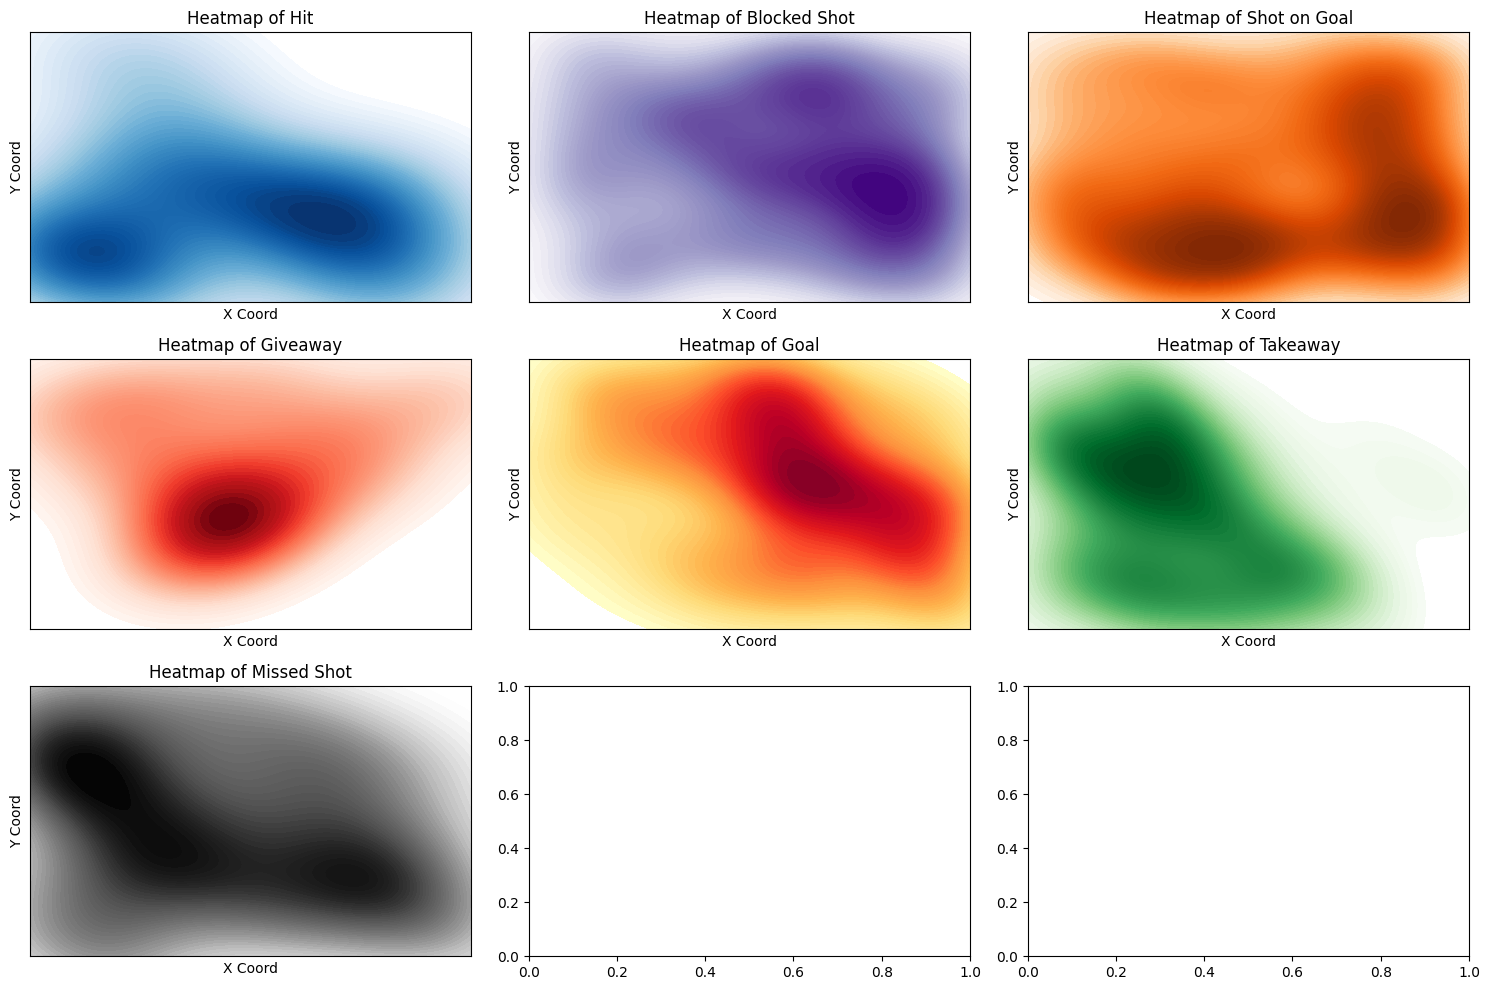

In [24]:
# Create heatmaps for each action type showing where on the rink the AI makes different plays.

# Load the logged actions file
log_file = "../outputs/hockey_action_log_after.csv"
df_log = pd.read_csv(log_file)

# Define action mapping colors for visualization
action_colors = {
    "Hit": "Blues",
    "Blocked Shot": "Purples",
    "Takeaway": "Greens",
    "Giveaway": "Reds",
    "Shot on Goal": "Oranges",
    "Missed Shot": "Greys",
    "Goal": "YlOrRd"
}

# Create a rink-sized heatmap
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # 3x3 grid for 7 actions
axes = axes.flatten()

# Loop through each action type
for idx, action in enumerate(df_log["Action Name"].unique()):
    ax = axes[idx]

    # Filter data for this action
    df_action = df_log[df_log["Action Name"] == action]

    # Create heatmap
    sns.kdeplot(
        x=df_action["X Coord"], y=df_action["Y Coord"],
        cmap=action_colors[action], fill=True, ax=ax, levels=50
    )
    
    # Title and formatting
    ax.set_title(f"Heatmap of {action}")
    ax.set_xlim(-100, 100)  # Full rink width
    ax.set_ylim(-50, 50)  # Full rink height
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout
plt.tight_layout()
plt.show()


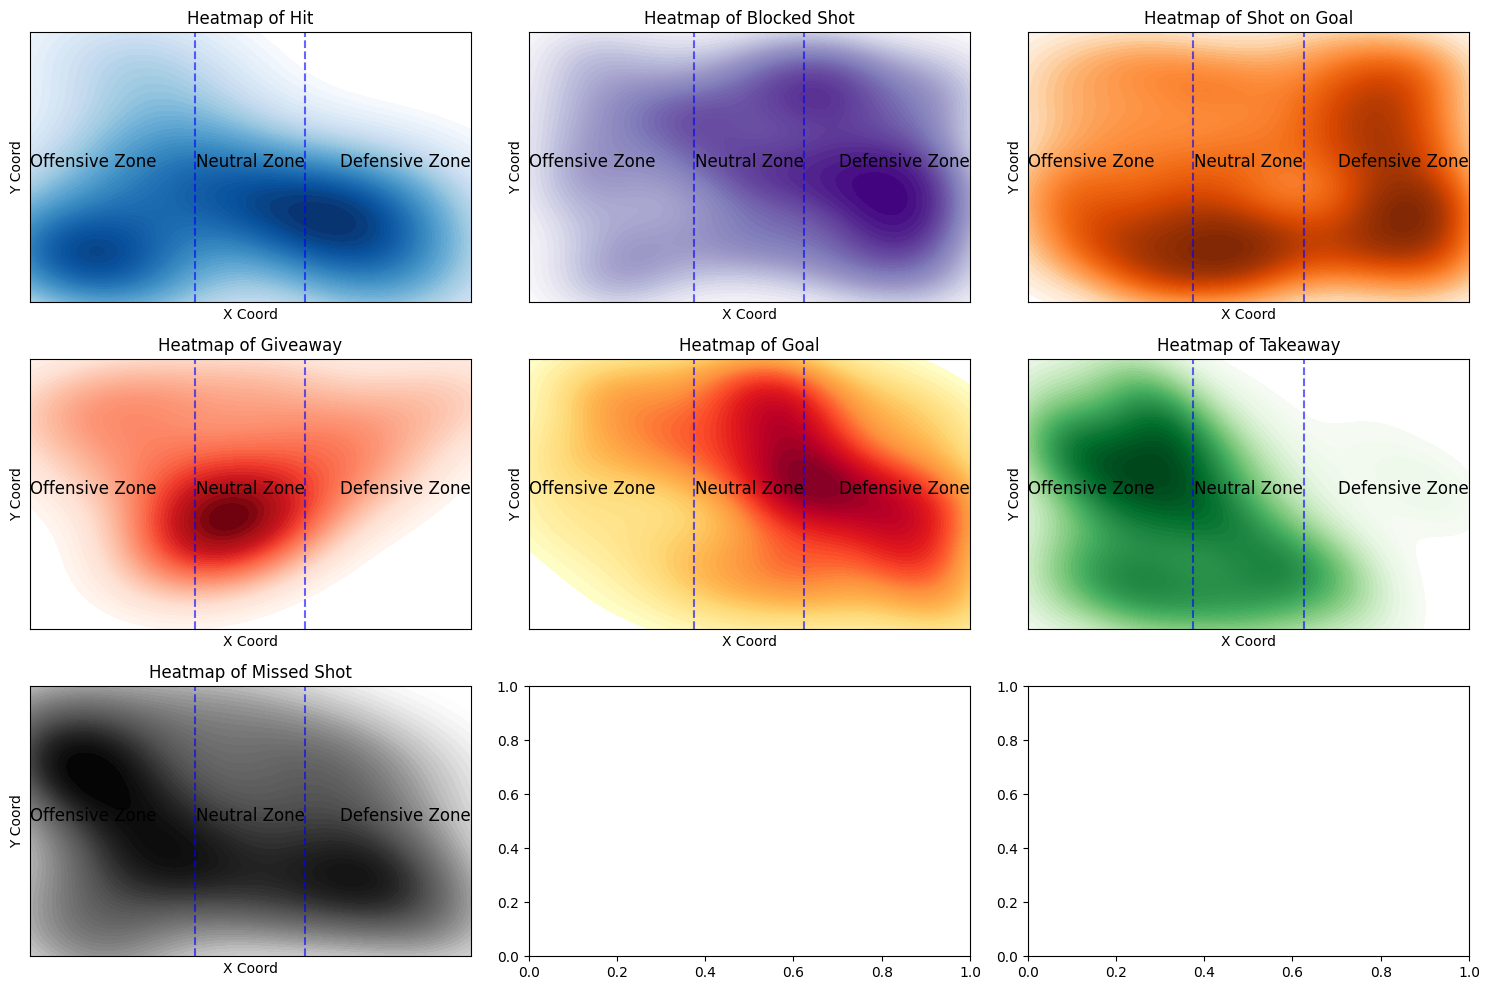

In [25]:
# Plot heatmaps for each action type showing where on the rink the AI makes different plays.
# Version 2 with zone overlays (Offensive, Neutral, Defensive)

# Define rink zones
zone_lines = [-25, 25]  # Boundaries between defensive/neutral/offensive zones (Neutral Zone: -25 to 25 on x-axis)

# Create heatmaps with zone overlays
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # 3x3 grid for 7 actions
axes = axes.flatten()

for idx, action in enumerate(df_log["Action Name"].unique()):
    ax = axes[idx]

    # Filter data for this action
    df_action = df_log[df_log["Action Name"] == action]

    # Create heatmap
    sns.kdeplot(
        x=df_action["X Coord"], y=df_action["Y Coord"],
        cmap=action_colors[action], fill=True, ax=ax, levels=50
    )
    
    # Draw zone boundaries
    for x in zone_lines:
        ax.axvline(x=x, color="blue", linestyle="dashed", alpha=0.6)

    # Label zones
    ax.text(-100, 0, 'Offensive Zone', fontsize=12, color='black', ha='left')
    ax.text(0, 0, 'Neutral Zone', fontsize=12, color='black', ha='center')
    ax.text(100, 0, 'Defensive Zone', fontsize=12, color='black', ha='right')

    # Title and formatting
    ax.set_title(f"Heatmap of {action}")
    ax.set_xlim(-100, 100)  # Full rink width
    ax.set_ylim(-50, 50)  # Full rink height
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

# Save heatmap
datetime = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
plt.savefig(f"../outputs/heatmap_{datetime}.png", bbox_inches='tight')

plt.show()

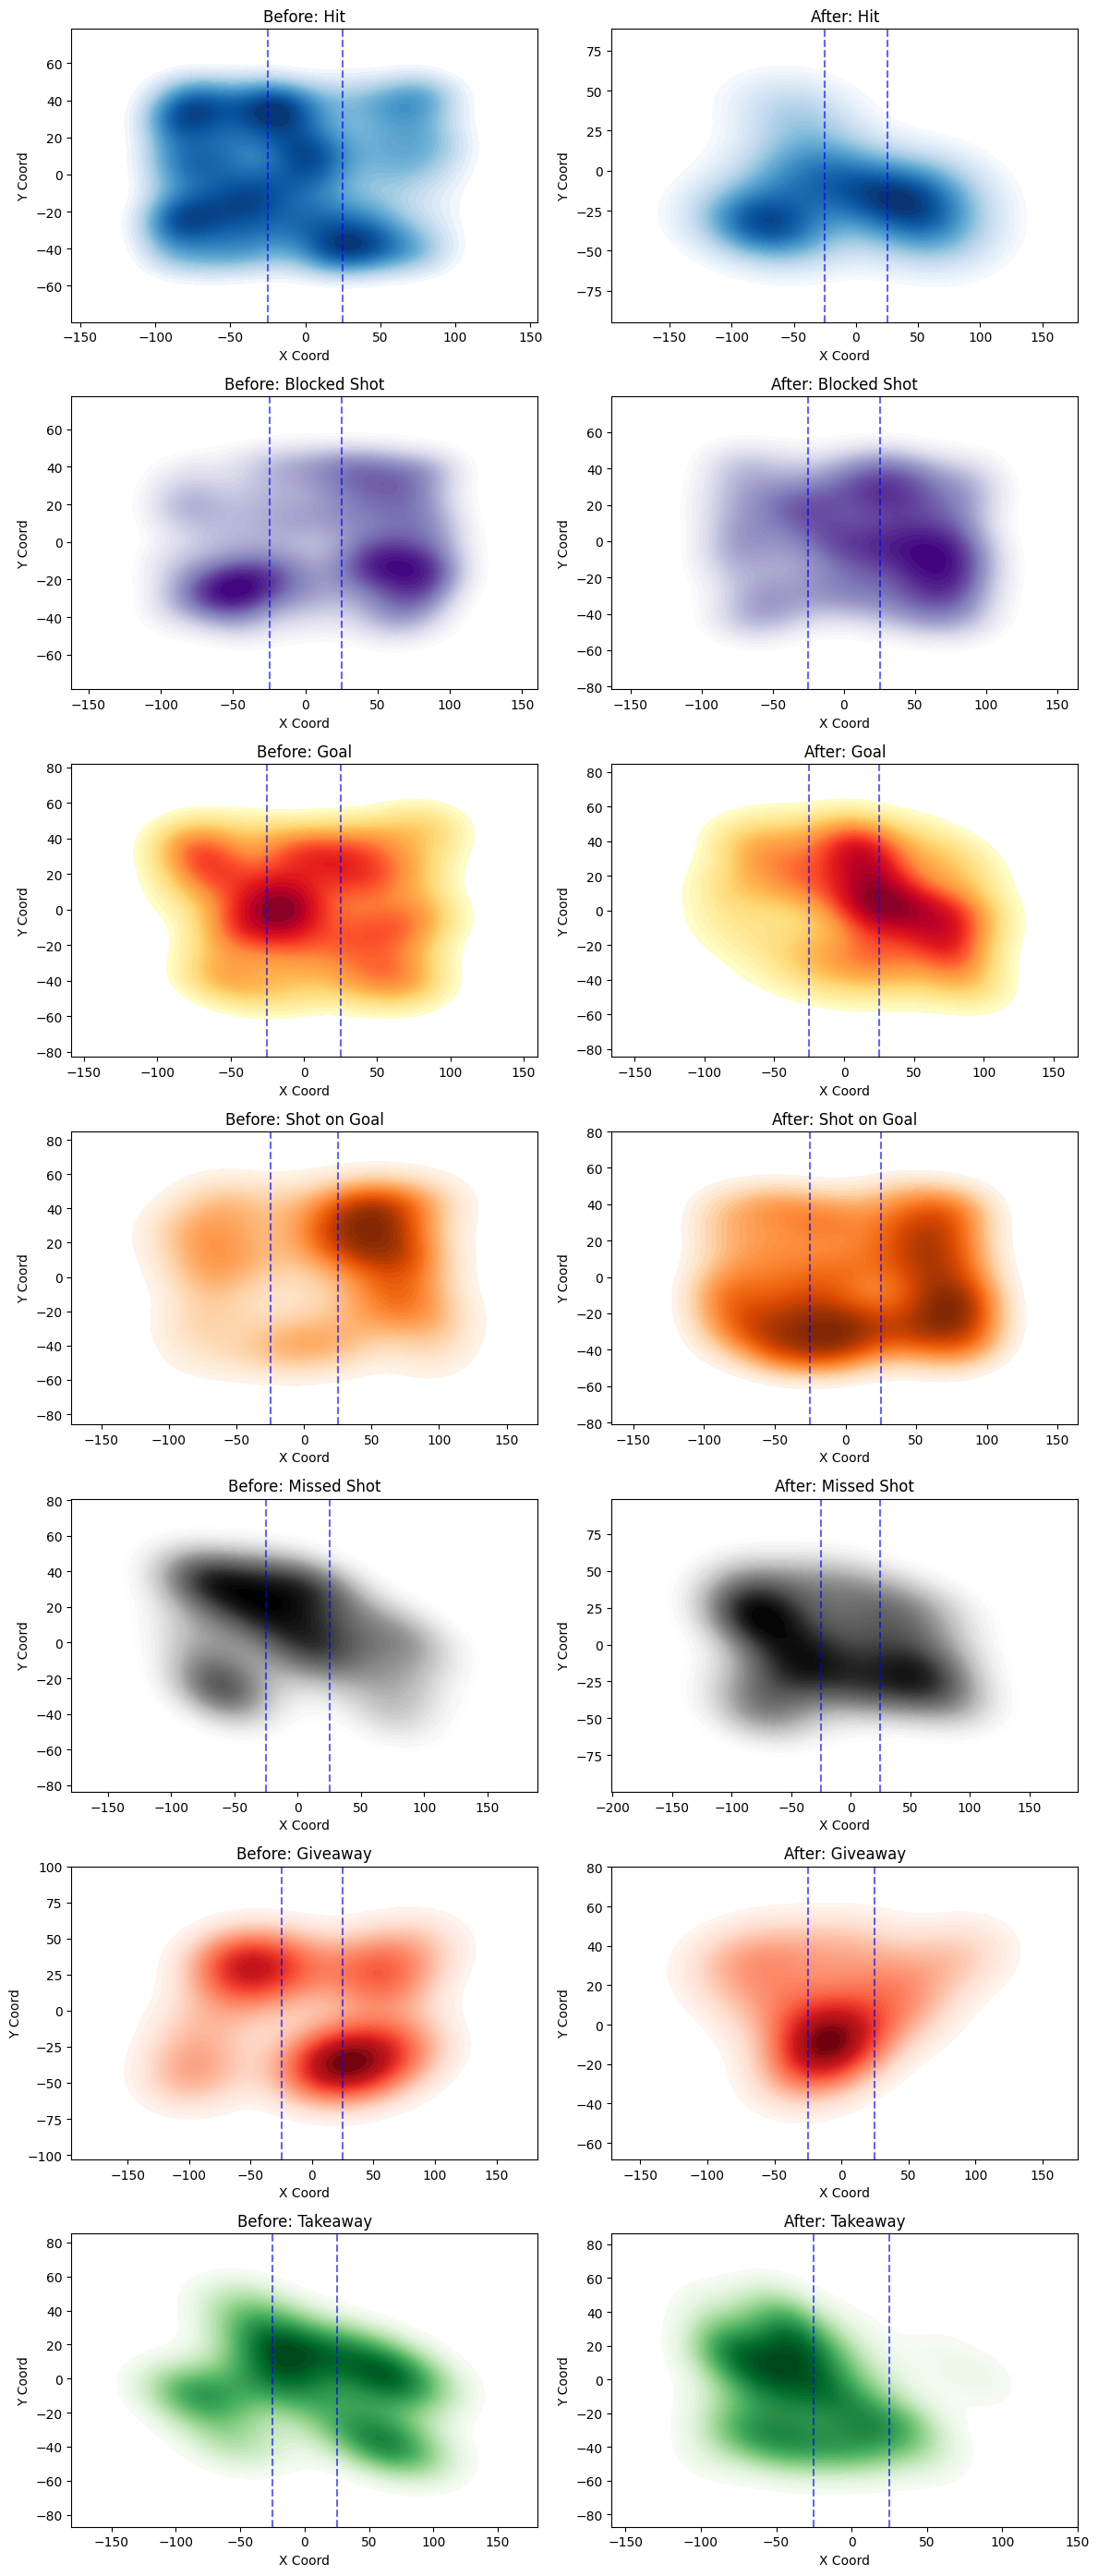

In [31]:
# Load before & after logs
df_before = pd.read_csv("../outputs/hockey_action_log_before.csv")  # Log before rink fix
df_after = pd.read_csv("../outputs/hockey_action_log_after.csv")    # Log after rink fix

# Define colors for different actions
action_colors = {
    "Hit": "Blues",
    "Blocked Shot": "Purples",
    "Takeaway": "Greens",
    "Giveaway": "Reds",
    "Shot on Goal": "Oranges",
    "Missed Shot": "Greys",
    "Goal": "YlOrRd"
}

# Define rink zones
zone_lines = [-25, 25]  # Boundaries between defensive/neutral/offensive zones

# Create heatmaps
fig, axes = plt.subplots(7, 2, figsize=(12, 28))  # 7 rows (actions), 2 columns (before & after)

for idx, action in enumerate(df_before["Action Name"].unique()):
    # Before heatmap
    ax_before = axes[idx, 0]
    df_action_before = df_before[df_before["Action Name"] == action]
    sns.kdeplot(x=df_action_before["X Coord"], y=df_action_before["Y Coord"], cmap=action_colors[action], fill=True, ax=ax_before, levels=50)
    ax_before.set_title(f"Before: {action}")
    for x in zone_lines:
        ax_before.axvline(x=x, color="blue", linestyle="dashed", alpha=0.6)

    # After heatmap
    ax_after = axes[idx, 1]
    df_action_after = df_after[df_after["Action Name"] == action]
    sns.kdeplot(x=df_action_after["X Coord"], y=df_action_after["Y Coord"], cmap=action_colors[action], fill=True, ax=ax_after, levels=50)
    ax_after.set_title(f"After: {action}")
    for x in zone_lines:
        ax_after.axvline(x=x, color="blue", linestyle="dashed", alpha=0.6)

plt.tight_layout()

# Save heatmap
datetime = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
plt.savefig(f"../outputs/heatmap_comparison_switch-ends_{datetime}.png", bbox_inches='tight')


plt.show()


In [34]:
!pip install ace_tools

In [36]:
import numpy as np
from IPython.display import display

def classify_zone(x_coord):
    """Classifies a zone based on X-coordinate."""
    if x_coord < -25:
        return "Defensive"
    elif -25 <= x_coord <= 25:
        return "Neutral"
    else:
        return "Offensive"

# Apply zone classification
df_before["Zone"] = df_before["X Coord"].apply(classify_zone)
df_after["Zone"] = df_after["X Coord"].apply(classify_zone)

# Count occurrences of actions in each zone
before_counts = df_before.groupby(["Action Name", "Zone"]).size().unstack(fill_value=0)
after_counts = df_after.groupby(["Action Name", "Zone"]).size().unstack(fill_value=0)

# Compare results
comparison_df = pd.concat([before_counts, after_counts], axis=1, keys=["Before", "After"])
print("Action Frequency by Zone (Before vs. After):")
display(comparison_df)

Action Frequency by Zone (Before vs. After):


Before                       After                  
Zone         Defensive Neutral Offensive Defensive Neutral Offensive
Action Name                                                         
Blocked Shot       198     118       270        94      80       144
Giveaway            16       8        18         4       6         3
Goal                88      84       112        31      45        54
Hit                368     226       237         6       1         4
Missed Shot         16      14         8        17       6        12
Shot on Goal        56      34       100       128      90       156
Takeaway            12       6        12        71      35        13

# **Section 4: Pre-Process Data** <a id="4"></a>

# **Section 5: Model** <a id="5"></a>

## **5.1. Model Definition** <a id="5.1"></a>


## **5.2. Model Training** <a id="5.2"></a>

 ## **5.3. Model Evaluation** <a id="5.3"></a>